# Identification of Handwritten Digits

Identification of handwritten digits are among the first important applications for
machine learning techniques. The MNIST database (Modified National Institute of Standards and
Technology database) is a famous database of handwritten digits which is commonly used in training
and evaluating machine learning models. In this notebook, five different types of machine learning
models (logistic regression, linear support vector machine, random forest, deep neural networks and
convolutional neural networks) were trained on the MNIST data. A grid search for hyperparameters
was applied to all the models to get the best performances af these models. They were then evaluated
in the MNIST test dataset as well as a data set from the USPS database. At last, all five models were
combined by both a direct hard voting and boosting hard voting approaches as an effort to achieve a
better performance. The objective of this project is to explore the strength and weakness of different
machine learning models.

In [1]:
# import necessary python modules
import numpy as np
import random
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from os import listdir
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.callbacks import EarlyStopping, TensorBoard
import pickle
import gzip

C:\Users\yiqichen\UB\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Define the logistic regression model class

In [2]:
class logistic_regression:
    def __init__(self, lamb, lr, epoch):
        """lamb, lr: regularization term and learning rate, respectively.
        epoch: number of epochs ro run."""
        
        self.lamb = lamb
        self.lr = lr
        self.epoch = epoch
        
    def softmax(self, z):
        """ The logistic softmax function."""

        return np.exp(z)/sum(np.exp(z))        
    
    def train(self, x_train, y_train, silent):
        """ This function performs the stochastic gradient descent solution for weight w on logistic regression.
        Inputs:
        x_train: Training data.
        y_train: Trainig label.
        silent: whether to output the training progress."""

        w = np.random.uniform(low=0.0, high=1.0, size=(y_train.shape[1], x_train.shape[1]))
        for j in range(self.epoch):
            sum_error = 0
            rand_index = np.random.permutation(list(range(y_train.shape[0])))
            for i in rand_index:        
                E_del = -np.outer((y_train[i]-self.softmax(w.dot(x_train[i].T))),x_train[i].T)+self.lamb*w
                sum_error += np.sum(E_del**2) / y_train.shape[0]
                w = w - self.lr*E_del
            if not silent:
                print('>epoch={}, lrate={}, error={}'.format(j+1, self.lr, sum_error))

        return w  

    def EMS(self, weight, x_input, y_input, label_input):
        """ This function returns the EMS for categorical cross entropy and accuracy for logistic regression.
        weight: the weight matrix for logistic regression.
        x_input: the input data matrix.
        y_input: the traget matrix.
        label_input: the label vector."""

        y_pred = self.softmax(weight.dot(x_input.T)).T
        entropy = 0
        for i in range(len(label_input)):
            entropy += -np.dot(y_input[i],np.log(y_pred[i]))
        entropy = np.sqrt(2*(entropy+np.sqrt(np.sum(weight**2))*self.lamb) / len(label_input))
        count = 0 
        for i in range(len(label_input)):
            if np.argmax(y_pred[i]) == label_input[i]:
                count += 1
        return entropy, count/len(label_input) 
    
    def predict(self, weight, x_input):
        return self.softmax(weight.dot(x_input.T)).T

## Define a function to perform the grid search for logistic regression model.

In [3]:
def select_params_logistic(lamb_list, lr_list, x_train, y_train, label_train, x_val, y_val, label_val, epoch):
    """ This function compares model performances from different parameters based on the validation accuracy for logistic regression.
    lamb_list: list of regularization factors to search.
    lr_list: list of learning rates to search.
    x_train, y_train, label_train: training data, training traget matrix and training labels. 
    x_val,y_val,label_val: validation data, validation target matrix and validation labels.
    epoch: number of epochs to run."""
    
    max_acc=0
    lamb_best = lamb_list[0]
    lr_best = lr_list[0]
    acc_all = np.zeros((lr_list.shape[0],lamb_list.shape[0]))
    for i in range(len(lr_list)):
        for j in range(len(lamb_list)):
            logreg = logistic_regression(lamb_list[j], lr_list[i], epoch)
            w = logreg.train(x_train, y_train, silent=True)
            E_val,acc_val = logreg.EMS(w, x_val, y_val, label_val)
            acc_all[i,j] = acc_val
            if acc_val > max_acc:
                max_acc = acc_val
                lamb_best = lamb_list[j]
                lr_best = lr_list[i]
    return lamb_best, lr_best, acc_all  


## Define functions to construct DNN models and searching for the best parameters

In [5]:
def get_dnn_model(drop_out,nodes):
    """" This function returns a two layer deep neural networks model.
    drop_out: Dropout rate.
    nodes: number of nodes in hidden layers."""
    
    first_dense_layer_nodes = nodes
    second_dense_layer_nodes = nodes
    
    model = Sequential()
    model.add(Dense(first_dense_layer_nodes, input_dim=784))
    model.add(Activation('relu'))
    model.add(Dropout(drop_out))

    model.add(Dense(second_dense_layer_nodes))
    model.add(Activation('relu'))
    model.add(Dropout(drop_out))

    model.add(Dense(10))
    model.add(Activation('softmax'))        

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model   

def get_best_params_dnn(x_train,y_train,x_val,y_val,nodes_list,do_list):
    """ This function searches for the best combination of the two hyperparameters in cnn 
    x_train, y_train: training data and training target matrix.
    x_val, y_val: validation data and validation target matrix.
    nodes_list: number of nodes in hidden layers to search from.
    do_list: dropout rates to search from."""
    
    # Specify some key parameters
    num_epochs = 100
    model_batch_size = 100
    tb_batch_size = 32
    early_patience = 20
    
    tensorboard_cb   = TensorBoard(log_dir='logs', batch_size= tb_batch_size, write_graph= True)
    earlystopping_cb = EarlyStopping(monitor='val_loss', verbose=1, patience=early_patience, mode='min')
    
    # First find the best number of nodes        
    val_acc_nodes = []
    for nodes in nodes_list:
        model = get_dnn_model(do_list[2],nodes)
        
        history = model.fit(x_train,
                            y_train,
                            validation_data=(x_val, y_val),
                            epochs=num_epochs,
                            batch_size=model_batch_size,
                            callbacks = [tensorboard_cb,earlystopping_cb],
                            verbose=0)
        print('nodes {} is tested.'.format(nodes))
        del model
        df = pd.DataFrame(history.history)
        val_acc_nodes.append(np.max(df['val_acc']))
    index = np.argmax(val_acc_nodes)
    nodes_best = nodes_list[index]
    print('Best number of nodes for this model is {}'.format(nodes_best))
    
    #Now choose the best dropout rate.
    val_acc_do = []
    for drop_out in do_list:
        model = get_dnn_model(drop_out,nodes_best)    
        
        history = model.fit(x_train,
                            y_train,
                            validation_data=(x_val, y_val),
                            epochs=num_epochs,
                            batch_size=model_batch_size,
                            callbacks = [tensorboard_cb,earlystopping_cb],
                            verbose=0)
        print('Dropout rate {} is tested.'.format(drop_out))
        del model
        df = pd.DataFrame(history.history)
        val_acc_do.append(np.max(df['val_acc']))
    index = np.argmax(val_acc_do)
    do_best = do_list[index]
    print('Best drop out for this model is {}'.format(do_best))
      
    
    return do_best, nodes_best,  val_acc_nodes, val_acc_do 
    
def accuracy_metrics(model,x_input,y_input):
    """ This function computes accuracies from machine learning model prediction.
    model: the model to make predictions.
    x_input: the test data.
    y_input: the test labels."""
    y = model.predict(x_input)
    y_pred = [np.argmax(a) for a in y]
    from sklearn.metrics import accuracy_score
    acc = accuracy_score(y_input,y_pred)
    return acc    

## Define functions to construct CNN models and searching for the best parameters

In [4]:
def get_cnn_model(filters,drop_out):
    """" This function returns a convolutional neural networks model which has one convolutional layer and one standard NN layer.
    filters: Number of filters.
    drop_out: Dropout rate."""
    
    model = Sequential()
    
    model.add(Conv2D(filters = filters, kernel_size=(3,3), activation='relu',
                    input_shape=(28,28,1)))
    model.add(BatchNormalization())  #Can make training faster
    model.add(Conv2D(filters = filters, kernel_size=(3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(strides=(2,2)))
    model.add(Dropout(drop_out)) #prevent overfitting
    
    model.add(Flatten()) #Compress output into one vector
    model.add(Dense(512, activation='relu')) #First hidden layer in NN
    model.add(Dropout(drop_out))
    model.add(Dense(10, activation='softmax')) #final output
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

def get_best_params_cnn(x_train,y_train,x_val,y_val,filter_list,do_list):
    """ This function searches for the best combination of the two hyperparameters in cnn 
    filter_list: number of filters to search from.
    do_list: dropout rates to search from."""
    
    # Specify key parameters
    num_epochs = 5
    model_batch_size = 200
    
    # First find the best number of filters        
    val_acc_filter = []
    for fil in filter_list:
        model = get_cnn_model(fil,do_list[2])
        
        history = model.fit(x_train,
                            y_train,
                            validation_data=(x_val, y_val),
                            epochs=num_epochs,
                            batch_size=model_batch_size,
                            verbose=1)
        print('Number of filter {} is tested.'.format(fil))
        del model
        df = pd.DataFrame(history.history)
        val_acc_filter.append(np.max(df['val_acc']))
    index = np.argmax(val_acc_filter)
    filter_best = filter_list[index]
    print('Best number of filter for this model is {}'.format(filter_best))
    
    #Now choose the best dropout rate.
    val_acc_do = []
    for drop_out in do_list:
        model = get_cnn_model(filter_list[2],drop_out)    
        
        history = model.fit(x_train,
                            y_train,
                            validation_data=(x_val, y_val),
                            epochs=num_epochs,
                            batch_size=model_batch_size,
                            verbose=1)
        print('Dropout rate {} is tested.'.format(drop_out))
        del model
        df = pd.DataFrame(history.history)
        val_acc_do.append(np.max(df['val_acc']))
    index = np.argmax(val_acc_do)
    do_best = do_list[index]
    print('Best drop out for this model is {}'.format(do_best))
    
    return filter_best, do_best, val_acc_filter, val_acc_do 

## Read in datasets

In [6]:
# Read USPS dataset
x_usps = []
label_usps = []
for j in range(10):
    train_files = [f for f in listdir('USPSdata/Numerals/'+str(j)+'/') if 'png' in f]
    for f in train_files:
        img = Image.open('USPSdata/Numerals/'+str(j)+'/'+f).convert('L').resize((28,28))
        arr = list(img.getdata())
        x_usps.append(arr)
        label_usps.append(j)
x_usps = np.array(x_usps)
label_usps = np.array(label_usps)

# Shuffle the dataset
indices = np.random.permutation(x_usps.shape[0])
x_usps_test = x_usps[indices,:]
label_usps_test = label_usps[indices]
# Normalize the dataset
x_usps_test = 1.0-x_usps_test/255.0

# Read MNIST data
filename = 'mnist.pkl.gz'
f = gzip.open(filename, 'rb')
training_data, validation_data, test_data = pickle.load(f, encoding='latin1')
f.close()
x_train, x_val, x_test = training_data[0], validation_data[0], test_data[0]
label_train, label_val, label_test = training_data[1], validation_data[1], test_data[1]

# One hot encoding for all the labels
y_train = np_utils.to_categorical(label_train).astype(np.float64)
y_val = np_utils.to_categorical(label_val).astype(np.float64)
y_test = np_utils.to_categorical(label_test).astype(np.float64)
y_usps_test = np_utils.to_categorical(label_usps_test).astype(np.float64)

# Model Training and Predicting

Five machine learning models are used to train the datasets. A grid search technique was applied in all models to find the optimum parameters. Because of the large size of the training set, it takes a very long time to perform the grid search. So the process was run once and then committed out. The best parameters were then hrad coded based on the grid search results. For the Gaussian support vector machines models, one single run takes 4-5 hrs, so it is impossible to run the grid search on them.

## Logistic Regression

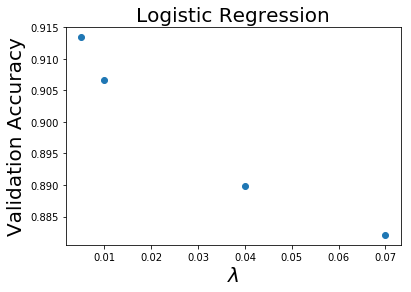

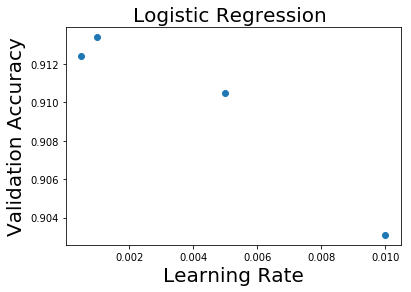

In [10]:
# Finding the best hyperparameters for logistic regression
lamb_list = [0.005, 0.01, 0.04, 0.07]
lr_list = [0.0005, 0.001, 0.005, 0.01] 
lamb_best, lr_best, Eval_all = select_params_logistic(np.array(lamb_list),np.array(lr_list),x_train,y_train,label_train,x_val,y_val,label_val,20)
lr_index = lr_list.index(lr_best)
lamb_index = lamb_list.index(lamb_best)
plt.figure()
plt.plot(lamb_list, Eval_all[lr_index,:],'o')
plt.xlabel(r'$\lambda$', fontsize=20)
plt.ylabel('Validation Accuracy', fontsize=20)
plt.title(r'Logistic Regression', fontsize=20)
plt.figure()
plt.plot(lr_list, Eval_all[:,lamb_index],'o')
plt.xlabel('Learning Rate', fontsize=20)
plt.ylabel('Validation Accuracy', fontsize=20)
plt.title(r'Logistic Regression ', fontsize=20)
plt.show()

In [7]:
#lamb_best = 0.005
#lr_best = 0.0005

# Construct the optimum logistic regression model
logreg = logistic_regression(lamb_best, lr_best, 20)
w = logreg.train(x_train, y_train, silent=True)
E_train, acc_train = logreg.EMS(w, x_train, y_train, label_train)
E_val, acc_val = logreg.EMS(w, x_val, y_val, label_val)
E_test, acc_test = logreg.EMS(w, x_test, y_test, label_test)
E_usps_test, acc_usps_test = logreg.EMS(w, x_usps_test, y_usps_test, label_usps_test)

print ('----------------------------------------------------')
print ("-------Logistic Regression Results-------")
print ('----------------------------------------------------')
print ("Best parameters: \nLambda = {} \nrate = {}".format(lamb_best,lr_best))
print ("EMS Training: {}, accuracy Training: {}".format(E_train,acc_train))
print ("EMS Validation: {}, accuracy Validation: {}".format(E_val,acc_val))
print ("EMS Testing: {}, accuracy Testing: {}".format(E_test,acc_test))    
print ("EMS USPS: {}, accuracy USPS: {}".format(E_usps_test,acc_usps_test))  


----------------------------------------------------
-------Logistic Regression Results-------
----------------------------------------------------
Best parameters: 
Lambda = 0.005 
rate = 0.0005
EMS Training: 0.854288798201265, accuracy Training: 0.90686
EMS Validation: 0.8236855110008077, accuracy Validation: 0.9144
EMS Testing: 0.8327609059090808, accuracy Testing: 0.9119
EMS USPS: 2.1661911857535077, accuracy USPS: 0.3642182109105455


In [11]:
# Calculate confusion matrices for both MNIST and USPS datasets
y_pred_log = logreg.predict(w, x_test)
label_pred_log = [np.argmax(y_pred_log[i]) for i in range(len(y_pred_log))]
cf_log = confusion_matrix(label_test, label_pred_log)
y_usps_pred_log = logreg.predict(w, x_usps_test)
label_usps_pred_log = [np.argmax(y_usps_pred_log[i]) for i in range(len(y_usps_pred_log))]
cf_usps_log = confusion_matrix(label_usps_test, label_usps_pred_log)
print ('\n')
print ('Confusion matrix by logistic regression model on MNIST test set:')
print (cf_log)
print ('Confusion matrix by logistic regression model on USPS test set:')
print (cf_usps_log)    



Confusion matrix by logistic regression model on MNIST test set:
[[ 961    0    2    1    1    1    9    1    4    0]
 [   0 1107    2    3    1    1    4    2   15    0]
 [  11    6  900   13   16    1   15   18   43    9]
 [   4    0   23  903    0   30    4   14   21   11]
 [   1    6    4    1  910    0    9    2    8   41]
 [  11    5    4   41   10  747   15   10   40    9]
 [  13    3    5    1   11   12  908    1    4    0]
 [   3   17   25    5    8    0    0  932    3   35]
 [   7    9    8   22    9   26   13   14  852   14]
 [  11    7    4   11   37    9    0   24    7  899]]
Confusion matrix by logistic regression model on USPS test set:
[[ 618    2  256   52  228  128   73   50  162  431]
 [ 182  404   13  309  361   59   37  303  302   30]
 [ 201   23 1184  161   72   78   86   78   86   30]
 [  90    3  138 1263   22  265   16   74   85   44]
 [  53   81   45   51 1021   77   28  152  302  190]
 [ 160   25  137  181   49 1120  118   77   96   37]
 [ 294   14  384  10

## Support Vectors Machines

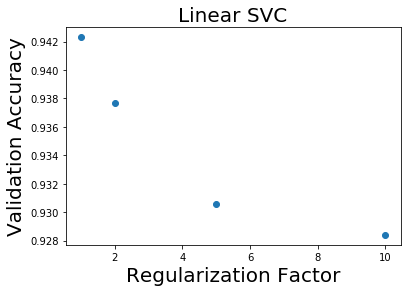

In [12]:
# Finding the best regularization factor for linear vector machines
C_factors = [1,2,5,10]
# Linear Kernel
#Find the best regularization factor to use  
acc_val_linear_all = []
for C in C_factors:
   svc_linear = SVC(kernel='linear', C=C)
   svc_linear.fit(x_train,label_train)
   acc_val_svc_linear = svc_linear.score(x_val,label_val)
   acc_val_linear_all.append(acc_val_svc_linear)
plt.figure()
plt.plot(C_factors, acc_val_linear_all, 'o')
plt.xlabel('Regularization Factor', fontsize=20)
plt.ylabel('Validation Accuracy', fontsize=20)
plt.title(r'Linear SVC', fontsize=20)
plt.show()

C_best_linear = C_factors[np.argmax(acc_val_linear_all)]    

In [15]:
#C_best_linear = 1

svc_linear = SVC(kernel='linear', C=C_best_linear)
svc_linear.fit(x_train,label_train)
acc_train_svc_linear, acc_val_svc_linear, acc_test_svc_linear = svc_linear.score(x_train,label_train), svc_linear.score(x_val,label_val), svc_linear.score(x_test,label_test)
acc_usps_test_svc_linear = svc_linear.score(x_usps_test, label_usps_test)
#y_pred_svc = svc.predict(x_test)

print ('\n')
print ('----------------------------------------------------')
print ("-------Support Vector Machine Results-------")
print ('----------------------------------------------------')
print ('Linear Kernel')
print ("Best parameter: regularization factor = {}".format(C_best_linear))
print ("accuracy Training: {}".format(acc_train_svc_linear))
print ("accuracy Validation: {}".format(acc_val_svc_linear))
print ("accuracy Testing: {}".format(acc_test_svc_linear))    
print ("accuracy USPS: {}".format(acc_usps_test_svc_linear)) 



----------------------------------------------------
-------Support Vector Machine Results-------
----------------------------------------------------
Linear Kernel
Best parameter: regularization factor = 1
accuracy Training: 0.97246
accuracy Validation: 0.9423
accuracy Testing: 0.939
accuracy USPS: 0.3272163608180409


In [16]:
# Calculate confusion matrices for both MNIST and USPS datasets
label_pred_svc = svc_linear.predict(x_test)
cf_svc = confusion_matrix(label_test, label_pred_svc)
label_usps_pred_svc = svc_linear.predict(x_usps_test)
cf_usps_svc = confusion_matrix(label_usps_test, label_usps_pred_svc)
print ('\n')
print ('Confusion matrix by linear svc model on MNIST test set:')
print (cf_svc)
print ('Confusion matrix by linear svc model on USPS test set:')
print (cf_usps_svc)    



Confusion matrix by linear svc model on MNIST test set:
[[ 959    0    5    2    2    4    7    0    1    0]
 [   0 1121    3    3    0    1    2    1    4    0]
 [   6    8  968    9    3    2   11   10   13    2]
 [   5    2   17  944    4   13    1    8   13    3]
 [   2    1   10    1  943    0    4    2    2   17]
 [  13    4    2   39    5  792    9    1   22    5]
 [  10    3   11    1    5   14  911    2    1    0]
 [   1    8   20   10    6    1    0  961    3   18]
 [   8    4    9   25   11   27    6    5  871    8]
 [   7    6    2   13   32    4    0   18    7  920]]
Confusion matrix by linear svc model on USPS test set:
[[ 483    3  320   70  254  298   58  125   14  375]
 [  60  475  136  300  342  167   22  413   62   23]
 [ 176   91 1163  126   55  209   60   62   37   20]
 [  70   59  294  922   14  509    5   54   54   19]
 [  26   25  136   76  884  194    9  463   84  103]
 [  60   17  166  250   85 1203   36   50  104   29]
 [ 168   23  730   50  154  312  539  

In [17]:
##     Radial Basis Functions Kernel with gamma = 1
#    svc_rbf1 = SVC(kernel='rbf', gamma=1)
#    svc_rbf1.fit(x_train,label_train)
#    acc_train_svc_rbf1, acc_val_svc_rbf1, acc_test_svc_rbf1 = svc_rbf1.score(x_train,label_train), svc_rbf1.score(x_val,label_val), svc_rbf1.score(x_test,label_test)
#    acc_usps_test_svc_rbf1 = svc_rbf1.score(x_usps_test, label_usps_test)    
#
#    print ('\n')    
#    print ('----------------------------------------------------')    
#    print ('Radial Basis Function Kernel')
#    print ('gamma=1')
#    print ("accuracy Training: {}".format(acc_train_svc_rbf1))
#    print ("accuracy Validation: {}".format(acc_val_svc_rbf1))
#    print ("accuracy Testing: {}".format(acc_test_svc_rbf1))    
#    print ("accuracy USPS: {}".format(acc_usps_test_svc_rbf1))
#    label_pred_svc_rbf1 = svc_rbf1.predict(x_test)
#    cf_svc_rbf1 = confusion_matrix(label_test, label_pred_svc_rbf1)
#    label_usps_pred_svc_rbf1 = svc_rbf1.predict(x_usps_test)
#    cf_usps_svc_rbf1 = confusion_matrix(label_usps_test, label_usps_pred_svc_rbf1)
#    print ('\n')
#    print ('Confusion matrix by rbf svc model (gamma=1.0) on MNIST test set:')
#    print (cf_svc_rbf1)
#    print ('Confusion matrix by rbf svc model (gamma=1.0) on USPS test set:')
#    print (cf_usps_svc_rbf1)

In [18]:
##     Radial Basis Functions Kernel with gamma = auto
    
#    svc_rbf2 = SVC(kernel='rbf', gamma='auto')
#    svc_rbf2.fit(x_train,label_train)
#    acc_train_svc_rbf2, acc_val_svc_rbf2, acc_test_svc_rbf2 = svc_rbf2.score(x_train,label_train), svc_rbf2.score(x_val,label_val), svc_rbf2.score(x_test,label_test)
#    acc_usps_test_svc_rbf2 = svc_rbf2.score(x_usps_test, label_usps_test)   
#   
#    print ('gamma=auto')
#    print ("accuracy Training: {}".format(acc_train_svc_rbf2))
#    print ("accuracy Validation: {}".format(acc_val_svc_rbf2))
#    print ("accuracy Testing: {}".format(acc_test_svc_rbf2))    
#    print ("accuracy USPS: {}".format(acc_usps_test_svc_rbf2))
#    label_pred_svc_rbf2 = svc_rbf2.predict(x_test)
#    cf_svc_rbf2 = confusion_matrix(label_test, label_pred_svc_rbf2)
#    label_usps_pred_svc_rbf2 = svc_rbf2.predict(x_usps_test)
#    cf_usps_svc_rbf2 = confusion_matrix(label_usps_test, label_usps_pred_svc_rbf2)
#    print ('\n')
#    print ('Confusion matrix by rbf svc model (gamma=auto) on MNIST test set:')
#    print (cf_svc_rbf2)
#    print ('Confusion matrix by rbf svc model (gamma=auto) on USPS test set:')
#    print (cf_usps_svc_rbf2)

## Random Forest

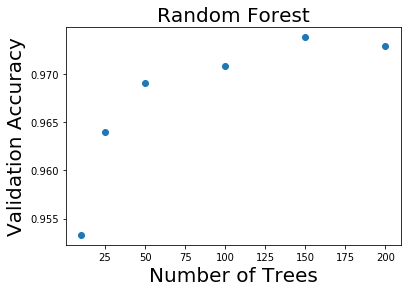

In [19]:
# Find the best number of trees to use
n_trees = [10,25,50,100,150,200]
acc_val_all = []
for n in n_trees:
   rf = RandomForestClassifier(n_estimators=n)
   rf.fit(x_train,label_train)
   acc_val_rf = rf.score(x_val,label_val)    
   acc_val_all.append(acc_val_rf)
plt.figure()
plt.plot(n_trees, acc_val_all,'o')
plt.xlabel('Number of Trees', fontsize=20)
plt.ylabel('Validation Accuracy', fontsize=20)
plt.title(r'Random Forest', fontsize=20)
plt.show()

n_trees_best = n_trees[np.argmax(acc_val_all)]

In [20]:
n_trees_best = 200

rf = RandomForestClassifier(n_estimators=n_trees_best)
rf.fit(x_train,label_train)
acc_train_rf, acc_val_rf, acc_test_rf = rf.score(x_train,label_train), rf.score(x_val,label_val), rf.score(x_test,label_test)
acc_usps_test_rf = rf.score(x_usps_test, label_usps_test)
#y_pred_svc = svc.predict(x_test)

print ('\n')
print ('----------------------------------------------------')
print ("-------Random Forests Results-------")
print ('----------------------------------------------------')
print ("Best parameters: \nnumber of trees = {}".format(n_trees_best))
print ("accuracy Training: {}".format(acc_train_rf))
print ("accuracy Validation: {}".format(acc_val_rf))
print ("accuracy Testing: {}".format(acc_test_rf))    
print ("accuracy USPS: {}".format(acc_usps_test_rf)) 



----------------------------------------------------
-------Random Forests Results-------
----------------------------------------------------
Best parameters: 
number of trees = 200
accuracy Training: 1.0
accuracy Validation: 0.973
accuracy Testing: 0.9698
accuracy USPS: 0.41217060853042653


In [21]:
# Calculate confusion matrices for both MNIST and USPS datasets
label_pred_rf = rf.predict(x_test)
cf_rf = confusion_matrix(label_test, label_pred_rf)
label_usps_pred_rf = rf.predict(x_usps_test)
cf_usps_rf = confusion_matrix(label_usps_test, label_usps_pred_rf)
print ('\n')
print ('Confusion matrix by random forest model on MNIST test set:')
print (cf_rf)
print ('Confusion matrix by random forest model on USPS test set:')
print (cf_usps_rf)



Confusion matrix by random forest model on MNIST test set:
[[ 969    0    1    0    0    3    3    1    3    0]
 [   0 1124    2    3    1    1    3    0    1    0]
 [   6    0 1001    4    2    1    4    8    6    0]
 [   0    0   11  973    0    7    0    8    8    3]
 [   1    0    2    0  955    0    4    0    3   17]
 [   2    0    0   16    3  856    7    2    5    1]
 [   8    3    0    0    3    4  937    0    3    0]
 [   1    3   19    2    2    0    0  991    1    9]
 [   5    0    4    6    5    5    4    4  930   11]
 [   7    5    2    9   10    5    1    4    4  962]]
Confusion matrix by random forest model on USPS test set:
[[ 627   19  258   63  424  157   53  125    1  273]
 [   5  696   27   97   18  143   31  981    1    1]
 [  66   41 1263   65   55  208   13  283    3    2]
 [  36    9   76 1239   44  376    0  197    4   19]
 [  10  218   36   24 1075  188   10  391   19   29]
 [  67   39   76   66   22 1580   10  132    2    6]
 [ 288   58  238   25  103  383 

## Deep Neural Networks

Epoch 00033: early stopping
nodes 128 is tested.
Epoch 00033: early stopping
nodes 256 is tested.
Epoch 00027: early stopping
nodes 512 is tested.
Epoch 00027: early stopping
nodes 1024 is tested.
Best number of nodes for this model is 256
Epoch 00030: early stopping
Dropout rate 0.1 is tested.
Epoch 00025: early stopping
Dropout rate 0.2 is tested.
Epoch 00032: early stopping
Dropout rate 0.3 is tested.
Epoch 00029: early stopping
Dropout rate 0.4 is tested.
Best drop out for this model is 0.4


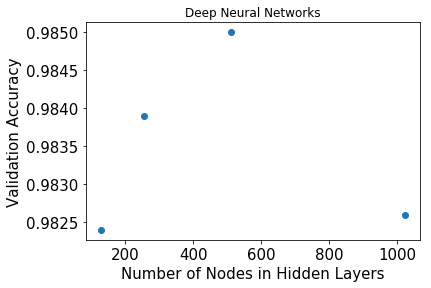

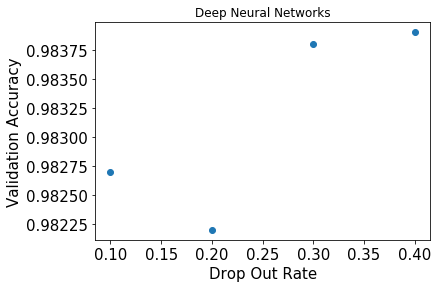

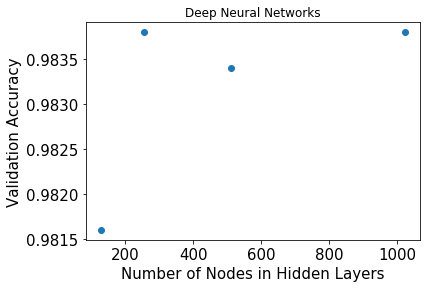

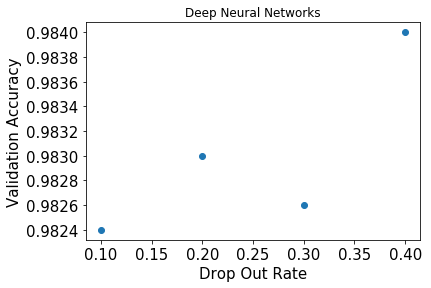

In [23]:
# Find the best paramters for DNN
nodes_list = [128,256,512,1024]
do_list = [0.1,0.2,0.3,0.4]

do_best, nodes_best, val_acc_nodes, val_acc_do = get_best_params_dnn(x_train,y_train,x_val,y_val,nodes_list,do_list)    

plt.figure()
plt.plot(nodes_list, val_acc_nodes, 'o')
plt.xlabel('Number of Nodes in Hidden Layers', fontsize=15)
plt.ylabel('Validation Accuracy', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Deep Neural Networks')
plt.figure()
plt.plot(do_list, val_acc_do, 'o')
plt.xlabel('Drop Out Rate', fontsize=15)
plt.ylabel('Validation Accuracy', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Deep Neural Networks')
plt.show()

In [24]:
#do_best = 0.3
#nodes_best = 1024

dnn_best = get_dnn_model(do_best, nodes_best)
tensorboard_cb   = TensorBoard(log_dir='logs', batch_size= 32, write_graph= True)
earlystopping_cb = EarlyStopping(monitor='val_loss', verbose=1, patience=20, mode='min')

history = dnn_best.fit(x_train,
                    y_train,
                    validation_data=(x_val, y_val),
                    epochs=100,
                    batch_size=100,
                    callbacks = [tensorboard_cb,earlystopping_cb],
                    verbose=1)    
df = pd.DataFrame(history.history)
df.plot(subplots=True, grid=True, figsize=(10,15))
plt.title('Deep Neural Networks Optimum Performance')

acc_train_dnn, acc_val_dnn, acc_test_dnn = accuracy_metrics(dnn_best, x_train,label_train), accuracy_metrics(dnn_best, x_val,label_val), accuracy_metrics(dnn_best, x_test,label_test)
acc_usps_test_dnn = accuracy_metrics(dnn_best, x_usps_test,label_usps_test)

print ('\n')
print ('----------------------------------------------------')
print ("-------Deep Neural Networks Results-------")
print ('----------------------------------------------------')
print ("Best parameters: \nnodes = {} \ndropout rate = {}".format(nodes_best,do_best))
print ("accuracy Training: {}".format(acc_train_dnn))
print ("accuracy Validation: {}".format(acc_val_dnn))
print ("accuracy Testing: {}".format(acc_test_dnn))    
print ("accuracy USPS: {}".format(acc_usps_test_dnn))

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 3s 59us/step - loss: 0.4090 - acc: 0.8747 - val_loss: 0.1387 - val_acc: 0.9604
Epoch 2/100
50000/50000 [==============================] - 3s 54us/step - loss: 0.1848 - acc: 0.9456 - val_loss: 0.1041 - val_acc: 0.9688
Epoch 3/100
50000/50000 [==============================] - 3s 53us/step - loss: 0.1426 - acc: 0.9565 - val_loss: 0.0890 - val_acc: 0.9734
Epoch 4/100
50000/50000 [==============================] - 3s 51us/step - loss: 0.1234 - acc: 0.9618 - val_loss: 0.0828 - val_acc: 0.9745
Epoch 5/100
50000/50000 [==============================] - 3s 52us/step - loss: 0.1032 - acc: 0.9687 - val_loss: 0.0761 - val_acc: 0.9766
Epoch 6/100
50000/50000 [==============================] - 3s 51us/step - loss: 0.0921 - acc: 0.9715 - val_loss: 0.0726 - val_acc: 0.9777
Epoch 7/100
50000/50000 [==============================] - 3s 52us/step - loss: 0.0855 - acc: 0.9735 - val_loss: 0.0738 - 

In [25]:
# Calculate confusion matrices for both MNIST and USPS datasets
y_pred_dnn = dnn_best.predict(x_test)
label_pred_dnn = [np.argmax(y_pred_dnn[i]) for i in range(len(y_pred_dnn))]
cf_dnn = confusion_matrix(label_test, label_pred_dnn)
y_usps_pred_dnn = dnn_best.predict(x_usps_test)
label_usps_pred_dnn = [np.argmax(y_usps_pred_dnn[i]) for i in range(len(y_usps_pred_dnn))]
cf_usps_dnn = confusion_matrix(label_usps_test, label_usps_pred_dnn)
print ('\n')
print ('Confusion matrix by DNN model on MNIST test set:')
print (cf_dnn)
print ('Confusion matrix by DNN model on USPS test set:')
print (cf_usps_dnn)    



Confusion matrix by DNN model on MNIST test set:
[[ 976    1    1    0    0    0    1    1    0    0]
 [   0 1123    2    2    0    3    2    0    3    0]
 [   2    2 1011    4    2    1    1    5    4    0]
 [   0    0    4  996    0    6    0    3    1    0]
 [   0    0    1    1  956    0    4    1    1   18]
 [   2    0    0   11    1  874    2    0    1    1]
 [   4    1    0    1    6    4  940    0    2    0]
 [   0    1    7    4    0    0    0 1014    0    2]
 [   4    1    1    6    1    5    1    5  946    4]
 [   1    2    0    1    3    7    0    3    2  990]]
Confusion matrix by DNN model on USPS test set:
[[ 690    7   86   66  237  103   72   37   63  639]
 [  57  765   33  118  512   39   34  298   85   59]
 [  72   27 1570   72   33   82   25   53   57    8]
 [   7   10  133 1503    6  286    7   21   17   10]
 [   8   72   20   24 1352   80   17  232  137   58]
 [  19    1   34  124   10 1670   26   30   63   23]
 [ 109   15  163   35   77  166 1373    6   42   14]

## Convolutional Neural Networks

In [26]:
# Reszie the x datasets
x_train_cnn = x_train.reshape(-1, 28, 28, 1)
x_val_cnn = x_val.reshape(-1,28,28,1)
x_test_cnn = x_test.reshape(-1,28,28,1)
x_usps_test_cnn = x_usps_test.reshape(-1,28,28,1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 755s 15ms/step - loss: 0.2741 - acc: 0.9179 - val_loss: 0.0743 - val_acc: 0.9773
Epoch 2/5
50000/50000 [==============================] - 748s 15ms/step - loss: 0.0961 - acc: 0.9700 - val_loss: 0.0496 - val_acc: 0.9848
Epoch 3/5
50000/50000 [==============================] - 753s 15ms/step - loss: 0.0654 - acc: 0.9787 - val_loss: 0.0468 - val_acc: 0.9854
Epoch 4/5
50000/50000 [==============================] - 752s 15ms/step - loss: 0.0532 - acc: 0.9829 - val_loss: 0.0417 - val_acc: 0.9883
Epoch 5/5
50000/50000 [==============================] - 754s 15ms/step - loss: 0.0423 - acc: 0.9865 - val_loss: 0.0369 - val_acc: 0.9889
Number of filter 8 is tested.
Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 1294s 26ms/step - loss: 0.2437 - acc: 0.9338 - val_loss: 0.0648 - val_acc: 0.9807
Epoch 2/5
50000/50000 [==================

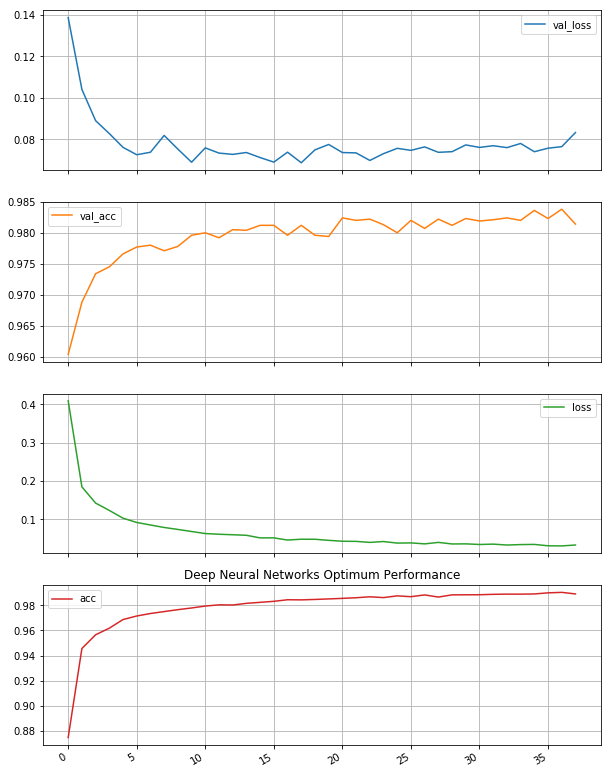

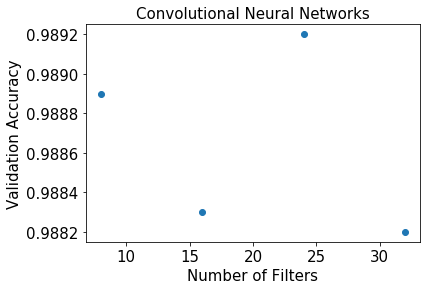

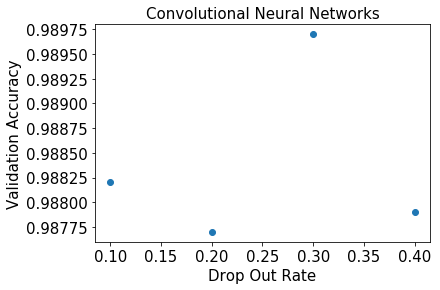

In [28]:
# Find the best parameters for CNN
filter_list = [8,16,24,32]
do_list = [0.1,0.2,0.3,0.4]

filter_best, do_best, val_acc_filter, val_acc_do = get_best_params_cnn(x_train_cnn,y_train,x_val_cnn,y_val,filter_list,do_list)

plt.figure()
plt.plot(filter_list, val_acc_filter, 'o')
plt.xlabel('Number of Filters', fontsize=15)
plt.ylabel('Validation Accuracy', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Convolutional Neural Networks',fontsize=15)
plt.figure()
plt.plot(do_list, val_acc_do, 'o')
plt.xlabel('Drop Out Rate', fontsize=15)
plt.ylabel('Validation Accuracy', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Convolutional Neural Networks',fontsize=15)
plt.show()

In [29]:
filter_best = 16
do_best_cnn = 0.3
cnn_best = get_cnn_model(filter_best,do_best_cnn)
history = cnn_best.fit(x_train_cnn,
                y_train,
                validation_data=(x_val_cnn,y_val),
                epochs=10,
                batch_size=200,
                verbose=1)

df = pd.DataFrame(history.history)
df.plot(subplots=True, grid=True, figsize=(10,15))
plt.title('Convolutional Neural Networks Optimum Performance')

acc_train_cnn, acc_val_cnn, acc_test_cnn = accuracy_metrics(cnn_best,x_train_cnn,label_train), accuracy_metrics(cnn_best,x_val_cnn,label_val), accuracy_metrics(cnn_best,x_test_cnn,label_test)
acc_usps_test_cnn = accuracy_metrics(cnn_best,x_usps_test_cnn,label_usps_test)

print ('\n')
print ('----------------------------------------------------')
print ("-------Convolutional Neural Networks Results-------")
print ('----------------------------------------------------')
print ("Best parameters: \nnumber of filters = {} \ndropout rate = {}".format(filter_best,do_best))
print ("accuracy Training: {}".format(acc_train_cnn))
print ("accuracy Validation: {}".format(acc_val_cnn))
print ("accuracy Testing: {}".format(acc_test_cnn))    
print ("accuracy USPS: {}".format(acc_usps_test_cnn))   

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 1285s 26ms/step - loss: 0.2349 - acc: 0.9344 - val_loss: 0.0631 - val_acc: 0.9830
Epoch 2/10
50000/50000 [==============================] - 1281s 26ms/step - loss: 0.0693 - acc: 0.9785 - val_loss: 0.0502 - val_acc: 0.9860
Epoch 3/10
50000/50000 [==============================] - 1283s 26ms/step - loss: 0.0506 - acc: 0.9846 - val_loss: 0.0416 - val_acc: 0.9875
Epoch 4/10
50000/50000 [==============================] - 1280s 26ms/step - loss: 0.0365 - acc: 0.9883 - val_loss: 0.0449 - val_acc: 0.9883
Epoch 5/10
50000/50000 [==============================] - 1281s 26ms/step - loss: 0.0322 - acc: 0.9898 - val_loss: 0.0458 - val_acc: 0.9881
Epoch 6/10
50000/50000 [==============================] - 1284s 26ms/step - loss: 0.0264 - acc: 0.9906 - val_loss: 0.0466 - val_acc: 0.9884
Epoch 7/10
50000/50000 [==============================] - 1282s 26ms/step - loss: 0.0227 - acc: 0.9920 - val_l

In [30]:
# Calculate confusion matrices for both MNIST and USPS datasets
y_pred_cnn = cnn_best.predict(x_test_cnn)
label_pred_cnn = [np.argmax(y_pred_cnn[i]) for i in range(len(y_pred_cnn))]
cf_cnn = confusion_matrix(label_test, label_pred_cnn)
y_usps_pred_cnn = cnn_best.predict(x_usps_test_cnn)
label_usps_pred_cnn = [np.argmax(y_usps_pred_cnn[i]) for i in range(len(y_usps_pred_cnn))]
cf_usps_cnn = confusion_matrix(label_usps_test, label_usps_pred_cnn)
print ('\n')
print ('Confusion matrix by CNN model on MNIST test set:')
print (cf_cnn)
print ('Confusion matrix by CNN model on USPS test set:')
print (cf_usps_cnn)    



Confusion matrix by CNN model on MNIST test set:
[[ 977    0    0    0    0    0    1    1    1    0]
 [   2 1128    1    1    0    1    0    1    1    0]
 [   1    0 1020    1    0    0    0    7    3    0]
 [   0    0    3  993    0    6    0    5    3    0]
 [   0    1    0    0  968    0    5    0    2    6]
 [   2    0    1    4    0  883    1    0    1    0]
 [   7    2    0    0    1    5  941    0    2    0]
 [   1    3    7    0    1    0    0 1016    0    0]
 [   2    0    2    0    0    2    0    3  964    1]
 [   0    3    2    0    7    3    0    4    2  988]]
Confusion matrix by CNN model on USPS test set:
[[ 604    0  186   19  203   28   18   27   36  879]
 [  23  838  193   31  242   72   25  552   14   10]
 [  38    6 1739   62   21   42    1   73   17    0]
 [   6    2   46 1713    1  210    0   18    3    1]
 [   0   26   34   23 1410   68    9  247  158   25]
 [   6    1   20   83    2 1802    1   42    2   41]
 [ 226   19  217   13   61   91 1282    2   53   36]

## Combining Models
##  1. Hard Majority Voting Method

In [31]:
label_pred_combine = []
for i in range(len(label_test)):
    label_temp = [label_pred_log[i], label_pred_svc[i], label_pred_rf[i], label_pred_dnn[i], label_pred_cnn[i]]
    label_pred_combine.append(max(set(label_temp), key=label_temp.count))
label_usps_pred_combine = []
for j in range(len(label_usps_test)):
    label_temp = [label_usps_pred_log[j], label_usps_pred_svc[j], label_usps_pred_rf[j], label_usps_pred_dnn[j], label_usps_pred_cnn[j]]
    label_usps_pred_combine.append(max(set(label_temp), key=label_temp.count))

# Calculate the accuracy of the combined model on different datasets
acc_test_combine, acc_usps_test_combine = accuracy_score(label_test,label_pred_combine), accuracy_score(label_usps_test,label_usps_pred_combine)
print ('\n')
print ('----------------------------------------------------')
print ("-------Combined Model (Hard Voting) Results-------")
print ('----------------------------------------------------')
print ("accuracy Testing: {}".format(acc_test_combine))    
print ("accuracy USPS: {}".format(acc_usps_test_combine))       



----------------------------------------------------
-------Combined Model (Hard Voting) Results-------
----------------------------------------------------
accuracy Testing: 0.9765
accuracy USPS: 0.49312465623281165


In [32]:
# Calculate confusion matrices for both MNIST and USPS datasets
cf_combine = confusion_matrix(label_test, label_pred_combine)
cf_usps_combine = confusion_matrix(label_usps_test, label_usps_pred_combine)
print ('\n')
print ('Confusion matrix by the combined model (hard voting) on MNIST test set:')
print (cf_combine)
print ('Confusion matrix by the combined model (hard voting) on USPS test set:')
print (cf_usps_combine)  



Confusion matrix by the combined model (hard voting) on MNIST test set:
[[ 973    0    1    1    0    1    1    1    2    0]
 [   0 1126    2    1    0    1    2    0    3    0]
 [   3    1 1006    3    2    0    1    8    7    1]
 [   0    0    7  985    0    5    0    5    7    1]
 [   1    0    2    0  961    0    5    0    2   11]
 [   2    0    0   15    0  864    3    1    5    2]
 [   9    2    1    0    3    6  935    0    2    0]
 [   0    4   15    1    1    0    0  999    1    7]
 [   6    0    3    4    5    5    2    4  941    4]
 [   6    5    2    7    7    1    0    4    2  975]]
Confusion matrix by the combined model (hard voting) on USPS test set:
[[ 713    4  228   40  244   92   26   30   36  587]
 [  64  735   47  207  291   94   15  478   60    9]
 [ 117   21 1589   50   36   85   18   53   23    7]
 [  36   11  133 1501    1  263    2   24   20    9]
 [  19   89   40   34 1272   94    5  221  164   62]
 [  49   11   79  115   19 1639   11   28   36   13]
 [ 258

## 2. Boosting Method

In [38]:
def missclassified(label_true,label_pred):
    miss_list = []
    for i in range(len(label_true)):
        if label_pred[i] != label_true[i]:
            miss_list.append(i)
    return miss_list

""" Construct all five models to be combined with """
svc_linear1 = SVC(kernel='linear', C=C_best_linear) 
rf1 = RandomForestClassifier(n_estimators=n_trees_best)
dnn1 = get_dnn_model(do_best, nodes_best)  
cnn1 = get_cnn_model(filter_best, do_best_cnn)

"""iteration 1: logistic regreesion. Select 60% of training set randomly with equal weights. Then train with logistic regression."""
index_list = list(range(x_train.shape[0]))
list1 = random.choices(index_list,k=int(0.6*x_train.shape[0]))
x_train1, y_train1 = x_train[list1,:], y_train[list1,:]
logreg1 = logistic_regression(lamb_best, lr_best, 20)
w1 = logreg1.train(x_train1, y_train1, silent=True)
y_pred_log1 = logreg1.predict(w1, x_train)
label_pred_log1 = [np.argmax(y_pred_log1[i]) for i in range(x_train.shape[0])]
miss_list1 = missclassified(label_train,label_pred_log1)
# Set the weights of missclassified samples 5 times higher
index_list += miss_list1*4

"""iteration 2: SVC. Select 60% of training set randomly with the new weights. Then train with linear SVC."""
list2 = random.choices(index_list,k=int(0.6*x_train.shape[0]))
x_train2, label_train2 = x_train[list2,:], label_train[list2]
svc_linear1.fit(x_train2, label_train2)
label_pred_svc1 = svc_linear1.predict(x_train)
miss_list2 = missclassified(label_train,label_pred_svc1)
index_list += miss_list2*4

"""iteration 3: Random Forest. Select 60% of training set randomly with the new weights. Then train with random forest."""
list3 = random.choices(index_list,k=int(0.6*x_train.shape[0]))
x_train3, label_train3 = x_train[list3,:], label_train[list3]
rf1.fit(x_train3, label_train3)
label_pred_rf1 = rf1.predict(x_train)
miss_list3 = missclassified(label_train,label_pred_rf1)
index_list += miss_list3*4    

"""iteration 4: DNN. Select 60% of training set randomly with the new weights. Then train with DNN."""
list4 = random.choices(index_list,k=int(0.6*x_train.shape[0]))
x_train4, y_train4 = x_train[list4,:], y_train[list4,:]
history = dnn1.fit(x_train4,
                    y_train4,
                    validation_data=(x_val, y_val),
                    epochs=100,
                    batch_size=100,
                    callbacks = [tensorboard_cb,earlystopping_cb],
                    verbose=1) 
y_pred_dnn1 = dnn1.predict(x_train)
label_pred_dnn1 = [np.argmax(y_pred_dnn1[i]) for i in range(len(y_pred_dnn1))]      
miss_list4 = missclassified(label_train,label_pred_dnn1)
index_list += miss_list4*4 

"""iteration 5: CNN. Select 60% of training set randomly with the new weights. Then train with CNN."""
list5 = random.choices(index_list,k=int(0.6*x_train.shape[0]))
x_train5, y_train5 = x_train_cnn[list5,:,:,:], y_train[list5,:]
history = cnn1.fit(x_train5,
            y_train5,
            validation_data=(x_val_cnn,y_val),
            epochs=5,
            batch_size=200,
            verbose=1)

Train on 30000 samples, validate on 10000 samples
Epoch 1/100
30000/30000 [==============================] - 2s 82us/step - loss: 0.7813 - acc: 0.7391 - val_loss: 0.1457 - val_acc: 0.9639
Epoch 2/100
30000/30000 [==============================] - 2s 65us/step - loss: 0.3402 - acc: 0.8906 - val_loss: 0.1016 - val_acc: 0.9710
Epoch 3/100
30000/30000 [==============================] - 2s 65us/step - loss: 0.2267 - acc: 0.9255 - val_loss: 0.0793 - val_acc: 0.9775
Epoch 4/100
30000/30000 [==============================] - 2s 63us/step - loss: 0.1641 - acc: 0.9454 - val_loss: 0.0790 - val_acc: 0.9769
Epoch 5/100
30000/30000 [==============================] - 2s 63us/step - loss: 0.1289 - acc: 0.9574 - val_loss: 0.0759 - val_acc: 0.9786
Epoch 6/100
30000/30000 [==============================] - 2s 64us/step - loss: 0.1062 - acc: 0.9655 - val_loss: 0.0741 - val_acc: 0.9791
Epoch 7/100
30000/30000 [==============================] - 2s 63us/step - loss: 0.0883 - acc: 0.9715 - val_loss: 0.0790 - 

In [40]:
# Use hard voting to combine these newly trained models
y_pred_log1 = logreg.predict(w1, x_test)
label_pred_log1 = [np.argmax(y_pred_log1[i]) for i in range(x_test.shape[0])]
y_usps_pred_log1 = logreg.predict(w1, x_usps_test)
label_usps_pred_log1 = [np.argmax(y_usps_pred_log1[i]) for i in range(x_usps_test.shape[0])]

label_pred_svc1 = svc_linear1.predict(x_test)
label_pred_rf1 = rf1.predict(x_test)
label_usps_pred_svc1 = svc_linear1.predict(x_usps_test)
label_usps_pred_rf1 = rf1.predict(x_usps_test)

y_pred_dnn1 = dnn1.predict(x_test)
label_pred_dnn1 = [np.argmax(y_pred_dnn1[i]) for i in range(len(y_pred_dnn1))]    
y_usps_pred_dnn1 = dnn1.predict(x_usps_test)
label_usps_pred_dnn1 = [np.argmax(y_usps_pred_dnn1[i]) for i in range(len(y_usps_pred_dnn1))]

y_pred_cnn1 = cnn1.predict(x_test_cnn)
label_pred_cnn1 = [np.argmax(y_pred_cnn1[i]) for i in range(len(y_pred_cnn1))]    
y_usps_pred_cnn1 = cnn1.predict(x_usps_test_cnn)
label_usps_pred_cnn1 = [np.argmax(y_usps_pred_cnn1[i]) for i in range(len(y_usps_pred_cnn1))]

label_pred_combine1 = []
for i in range(len(label_test)):
    label_temp = [label_pred_log1[i], label_pred_svc1[i], label_pred_rf1[i], label_pred_dnn1[i], label_pred_cnn1[i]]
    label_pred_combine1.append(max(set(label_temp), key=label_temp.count))
label_usps_pred_combine1 = []
for j in range(len(label_usps_test)):
    label_temp = [label_usps_pred_log1[j], label_usps_pred_svc1[j], label_usps_pred_rf1[j], label_usps_pred_dnn1[j], label_usps_pred_cnn1[j]]
    label_usps_pred_combine1.append(max(set(label_temp), key=label_temp.count))

In [41]:
# Calculate the accuracy of the combined model on different datasets
acc_test_combine1, acc_usps_test_combine1 = accuracy_score(label_test,label_pred_combine1), accuracy_score(label_usps_test,label_usps_pred_combine1)
print ('\n')
print ('----------------------------------------------------')
print ("-------Combined Model (Boosting) Results-------")
print ('----------------------------------------------------')
print ("accuracy Testing: {}".format(acc_test_combine1))    
print ("accuracy USPS: {}".format(acc_usps_test_combine1))   



----------------------------------------------------
-------Combined Model (Boosting) Results-------
----------------------------------------------------
accuracy Testing: 0.9809
accuracy USPS: 0.47747387369368466


In [42]:
# Calculate confusion matrices for both MNIST and USPS datasets
cf_combine1 = confusion_matrix(label_test, label_pred_combine1)
cf_usps_combine1 = confusion_matrix(label_usps_test, label_usps_pred_combine1)
print ('\n')
print ('Confusion matrix by the combined model (boosting) on MNIST test set:')
print (cf_combine1)
print ('Confusion matrix by the combined model (boosting) on USPS test set:')
print (cf_usps_combine1)  



Confusion matrix by the combined model (boosting) on MNIST test set:
[[ 971    0    2    0    0    1    2    1    3    0]
 [   0 1126    2    1    0    0    2    1    3    0]
 [   2    0 1014    1    1    0    2    6    5    1]
 [   0    0    2  992    0    4    0    3    6    3]
 [   1    0    2    0  966    0    3    0    2    8]
 [   2    0    1    6    0  871    4    1    4    3]
 [   6    3    2    0    1    4  942    0    0    0]
 [   0    5   18    0    1    0    0  998    2    4]
 [   6    0    3    3    3    1    0    2  953    3]
 [   8    5    0    7    6    1    0    3    3  976]]
Confusion matrix by the combined model (boosting) on USPS test set:
[[ 615    3  225   53  218   86   51   45   49  655]
 [  60  768   46  193  317   78   24  411   83   20]
 [  91   33 1593   68   24  103   19   33   28    7]
 [  32   11  126 1506    5  247    0   27   39    7]
 [  13  109   43   27 1179   85    6  298  176   64]
 [  37   18   88  131   12 1616   18   40   33    7]
 [ 193   23 